# Figures - appendices
----

In [16]:
# Imports
import sys
import os 
import numpy as np
import pandas as pd
from astropy.visualization import hist

from spaxelsleuth.loaddata.sami import load_sami_galaxies
from spaxelsleuth.plotting.plottools import plot_empty_BPT_diagram
from spaxelsleuth.plotting.plottools import vmin_fn, vmax_fn, label_fn, cmap_fn
from spaxelsleuth.plotting.plottools import bpt_colours, bpt_labels, bpt_ticks
from spaxelsleuth.plotting.plottools import morph_labels, morph_ticks
from spaxelsleuth.plotting.plottools import ncomponents_labels, ncomponents_colours
from spaxelsleuth.plotting.plottools import component_labels, component_colours
from spaxelsleuth.plotting.plotgalaxies import plot2dhistcontours

import matplotlib
from matplotlib import rc, rcParams
import matplotlib.pyplot as plt

rc("text", usetex=False)
rc("font",**{"family": "serif", "size": 14})
rcParams["savefig.bbox"] = "tight"
rcParams["savefig.format"] = "pdf"
plt.ion()
plt.close("all")


In [2]:
# Options
fig_path = "/priv/meggs3/u5708159/SAMI/figs/full_sample/"
savefigs = True
bin_type = "default"    # Options: "default" or "adaptive" for Voronoi binning
ncomponents = "recom"       # Options: "1" or "recom"
eline_SNR_min = 5


In [3]:
# Load the sample
df = load_sami_galaxies(ncomponents=ncomponents,
                        bin_type=bin_type,
                        eline_SNR_min=eline_SNR_min, 
                        vgrad_cut=False, 
                        sigma_gas_SNR_cut=True,
                        debug=False)

# Load the sample again, but this time WITHOUT making the velocity dispersion S/N cut
df_nocut = load_sami_galaxies(ncomponents=ncomponents,
                        bin_type=bin_type,
                        eline_SNR_min=eline_SNR_min, 
                        vgrad_cut=False, 
                        sigma_gas_SNR_cut=False,
                        debug=False)

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

# Appendix: beam smearing
---

### 2D histograms showing $v_{\rm grad}$ vs. $\sigma_{\rm gas}$, $\sigma_{\rm gas} - \sigma_*$ and $\sigma_{\rm gas}/\sigma_*$

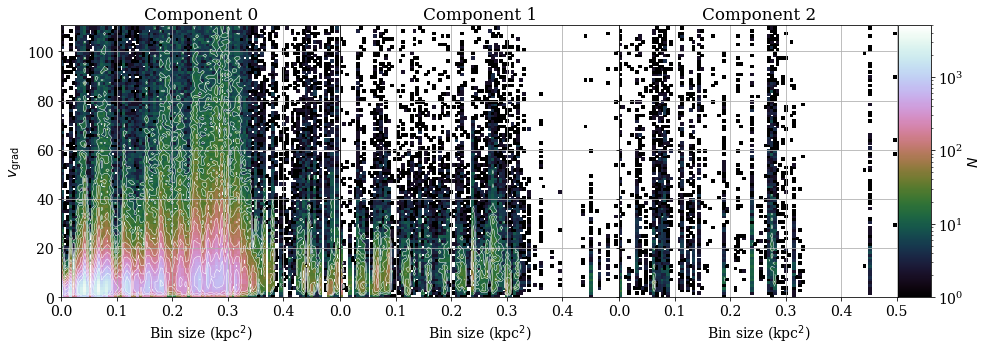

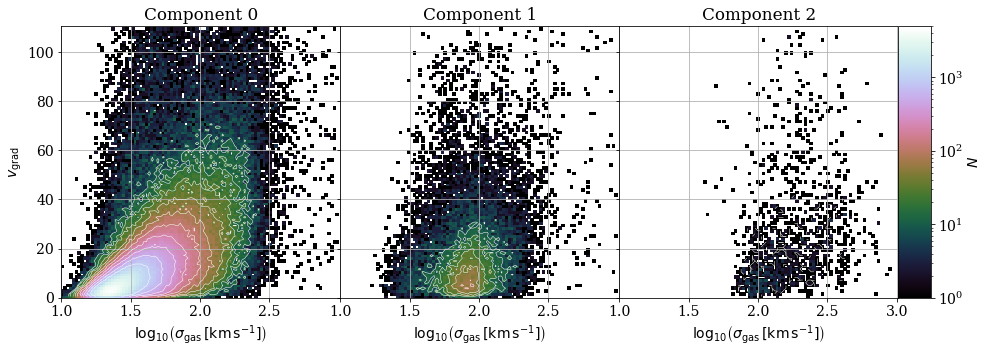

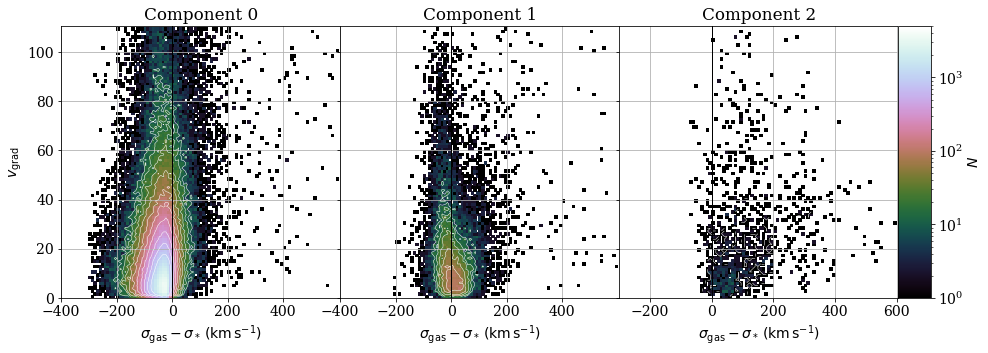

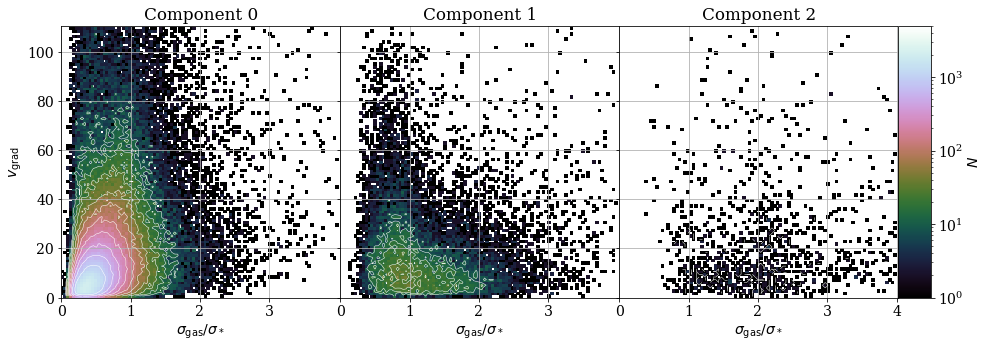

In [10]:
###############################################################################
# Plot v_grad vs. sigma_gas, sigma_gas - sigma_* and sigma_gas/sigma_*
###############################################################################
col_y = "v_grad"

for col_x in ["Bin size (square kpc)", "log sigma_gas", "sigma_gas - sigma_*", "sigma_gas/sigma_*"]:
    # Create new figure window
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5 * 3, 5))
    fig.subplots_adjust(wspace=0)
    bbox = axs[-1].get_position()
    cax = fig.add_axes([bbox.x0 + bbox.width, bbox.y0, 0.03, bbox.height])

    # Plot 
    for ii in range(3):
        plot2dhistcontours(df, 
                           col_x=f"{col_x} (component {ii})" if f"{col_x} (component {ii})" in df.columns else col_x,
                           col_y=f"{col_y} (component {ii})",
                           col_z="count", log_z=True,
                           ymin=0, ymax=110,
                           alpha=1.0, ax=axs[ii], cax=cax, nbins=100,
                           cmap="cubehelix", linewidths=0.5,
                           contours=True, hist=True, colors="white",
                           plot_colorbar=True if ii == 2 else False)
        # Decorations
        axs[ii].grid()
        axs[ii].set_ylabel("") if ii > 0 else None
        axs[ii].set_yticklabels([]) if ii > 0 else None
        axs[ii].set_title(f"Component {ii}")

        # Adjust the axis scaling
        axs[ii].get_children()[0].set_clim(1, 5e3)

    # Hide the last x-axis tick so they don't overlap
    for ax in axs[:-1]:
        ax.set_xticks(ax.get_xticks()[:-2])

    cax.set_ylabel(r"$N$")
    
    # Save 
    if savefigs:
        fig.savefig(os.path.join(fig_path, 
                                 f"v_grad_vs_{col_x.replace(' ', '_').replace('*', 'star').replace('/', '_over_')}" +\
                                 f"_{bin_type}_{ncomponents}"),
                                 bbox_inches="tight")

### Histograms of $\sigma_{\rm gas}$, $\sigma_{\rm gas} - \sigma_*$ and $\sigma_{\rm gas}/\sigma_*$ in slices of $v_{\rm grad}$

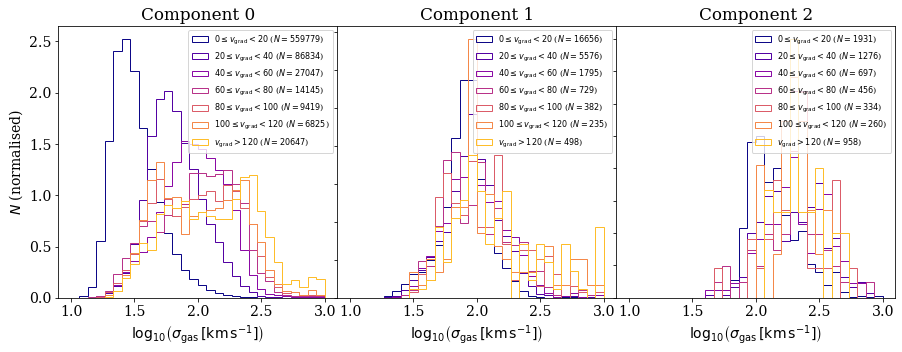

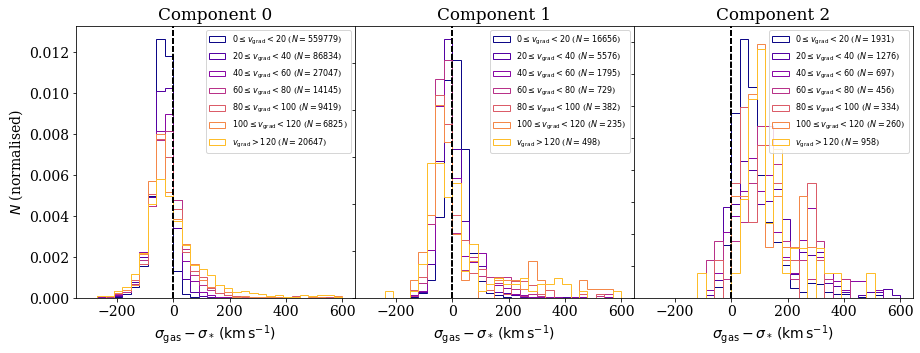

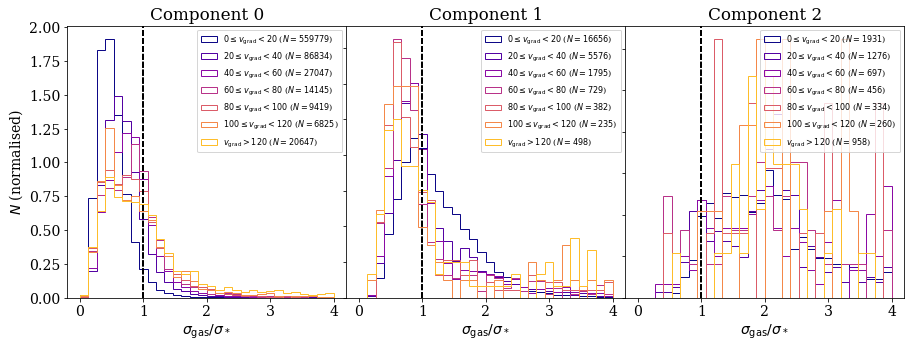

In [11]:
###############################################################################
# Histograms of sigma_gas, etc. in "slices" of v_grad
###############################################################################
v_grad_vals = np.linspace(0, 120, 7)
cmap_v_grad = plt.cm.get_cmap("plasma", len(v_grad_vals) + 1)

for col_x in ["log sigma_gas", "sigma_gas - sigma_*", "sigma_gas/sigma_*"]:
    # Create new figure window
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5 * 3, 5))
    fig.subplots_adjust(wspace=0)

    for vv, v_grad in enumerate(v_grad_vals):

        for ii in range(3):
            if v_grad < v_grad_vals[-1]:
                cond = (df[f"v_grad (component {ii})"] >= v_grad_vals[vv]) &\
                       (df[f"v_grad (component {ii})"] < v_grad_vals[vv + 1]) 
                df_cut = df[cond]
                label=r"$%d \leq v_{\rm grad} < %d$ ($N = %d$)" % (v_grad_vals[vv], v_grad_vals[vv + 1], df_cut.shape[0])
            else:
                cond = (df[f"v_grad (component {ii})"] >= v_grad_vals[vv])
                df_cut = df[cond]
                label=r"$v_{\rm grad} > %d$ ($N = %d$)" % (v_grad_vals[vv], df_cut.shape[0])

            
            axs[ii].hist(df_cut[f"{col_x} (component {ii})"], density=True, histtype="step", color=cmap_v_grad(vv), label=label,
                        range=(vmin_fn(col_x), vmax_fn(col_x)), bins=30)
            axs[ii].legend(fontsize="xx-small")

            # Decorations
            axs[ii].set_title(component_labels[ii])
            axs[ii].set_yticklabels([]) if ii > 0 else None
            axs[ii].set_xlabel(label_fn(col_x))
            if col_x == "sigma_gas - sigma_*":
                axs[ii].axvline(0, color="k", ls="--")
            if col_x == "sigma_gas/sigma_*":
                axs[ii].axvline(1, color="k", ls="--")

        axs[0].set_ylabel(r"$N$ (normalised)")
        # if col_x == "log sigma_gas":
        

        # Save 
        if savefigs:
            fig.savefig(os.path.join(fig_path, 
                                 f"hist_vgrad_{col_x.replace(' ', '_').replace('*', 'star').replace('/', '_over_')}" +\
                                 f"_{bin_type}_{ncomponents}"),
                                 bbox_inches="tight")

### 2D histogram of $\sigma_{\rm gas}$ vs. $v_{\rm grad}$ (replica of fig. 3 from Zhou+2017)

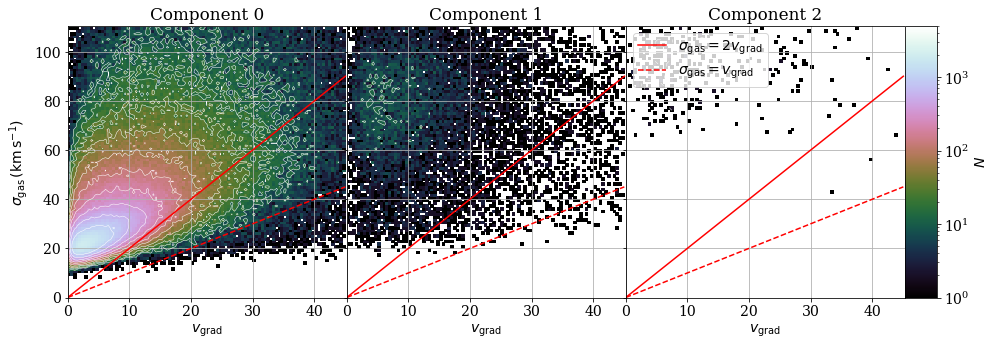

In [12]:
###############################################################################
# Recreate fig. 3 of Zhou+2017, but with the whole sample
###############################################################################
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5 * 3, 5))
fig.subplots_adjust(wspace=0)
bbox = axs[-1].get_position()
cax = fig.add_axes([bbox.x0 + bbox.width, bbox.y0, 0.03, bbox.height])

# recom components
col_x = "v_grad"
col_y = "sigma_gas"
for ii in range(3):
    plot2dhistcontours(df, 
                       col_x=f"{col_x} (component {ii})",
                          col_y=f"{col_y} (component {ii})",
                          col_z="count", log_z=True,
                          xmin=0, xmax=45, ymin=0, ymax=110,
                          alpha=1.0, ax=axs[ii], cax=cax, nbins=100,
                          cmap="cubehelix", linewidths=0.5,
                          contours=True, hist=True, colors="white",
                          plot_colorbar=True if ii == 2 else False)
    # Decorations
    axs[ii].grid()
    axs[ii].set_ylabel("") if ii > 0 else None
    axs[ii].set_yticklabels([]) if ii > 0 else None
    axs[ii].set_title(f"Component {ii}")
    axs[ii].plot([0, 45], [0, 90], "r", label=r"$\sigma_{\rm gas} = 2 v_{\rm grad}$")
    axs[ii].plot([0, 45], [0, 45], "r--", label=r"$\sigma_{\rm gas} = v_{\rm grad}$")
    axs[ii].set_xlabel(r"$v_{\rm grad}$")

    # Adjust the axis scaling
    axs[ii].get_children()[0].set_clim(1, 5e3)

axs[-1].legend()
cax.set_ylabel(r"$N$")

# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, f"sigma_gas_vs_v_grad_{bin_type}_{ncomponents}"), bbox_inches="tight")


# Appendix: velocity dispersion S/N cuts
---
### Histograms showing distribution in $\sigma_{\rm gas}$ for each component before and after the S/N cut


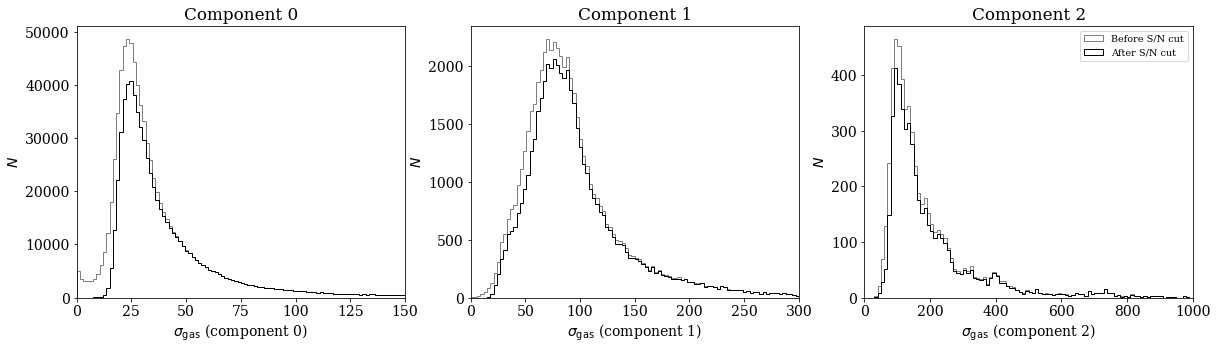

In [15]:
###############################################################################
# Plot the distribution in velocity dispersion before & after making the 
# S/N cut.
###############################################################################
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for ii, range_tup in zip(range(3), [(0, 150), (0, 300), (0, 1000)]):    
    # Plot.
    axs[ii].hist(df_nocut[f"sigma_gas (component {ii})"], histtype="step",
                 range=range_tup,
                 bins=100, color="grey", label="Before S/N cut")
    axs[ii].hist(df[f"sigma_gas (component {ii})"], histtype="step",
                 range=range_tup,
                 bins=100, color="k", label="After S/N cut")
    axs[ii].set_xlabel(r"$\sigma_{\rm gas}$ (component %d)" % ii)
    axs[ii].set_ylabel(r"$N$")
    axs[ii].set_title(f"Component {ii}")
    axs[ii].autoscale(axis="x", enable=True, tight=True)
axs[-1].legend(fontsize="x-small")

# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, "sigma_obs_cut_hist"),
                bbox_inches="tight")


### Scatter plot showing $\sigma_{\rm gs}$ S/N (observed) vs. $\sigma_{\rm gs}$ S/N (target)

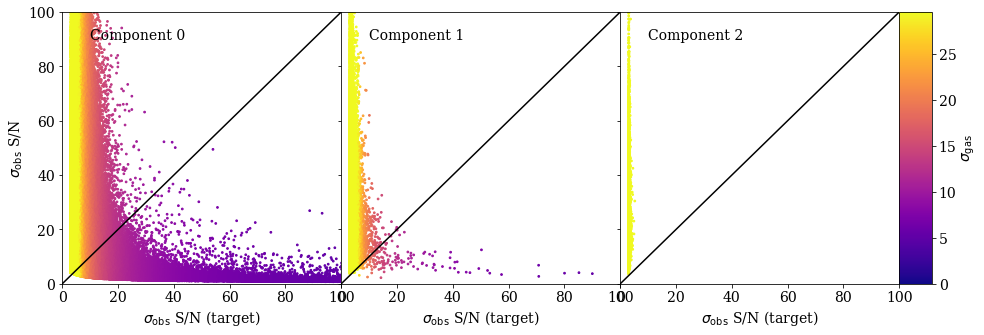

In [17]:
###############################################################################
# Make a scatter plot of SNR_obs vs. SNR_obs (min)
# w/ 1:1 line shown. Coloured by velocity dispersion.
###############################################################################
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
fig.subplots_adjust(wspace=0)
bbox = axs[-1].get_position()
cax = fig.add_axes([bbox.x0 + bbox.width, bbox.y0, 0.03, bbox.height])

sigma_inst = 29.6
for ii in range(3):
    # Scatter
    m = axs[ii].scatter(x=df_nocut[f"sigma_obs target S/N (component {ii})"],
                    y=df_nocut[f"sigma_obs S/N (component {ii})"],
                    c=df_nocut[f"sigma_gas (component {ii})"], s=3,
                    vmin=0, vmax=sigma_inst, cmap="plasma")
    points = axs[ii].collections[0]
    points.set_rasterized(True)
    axs[ii].plot([0, 200], [0, 200], color="k")
    axs[ii].set_xlim([0, 100])
    axs[ii].set_ylim([0, 100]) 
    axs[ii].set_xlabel(r"$\sigma_{\rm obs}$ S/N (target)")
    axs[ii].text(s=f"Component {ii}", x=0.1, y=0.9, transform=axs[ii].transAxes)
plt.colorbar(mappable=m, cax=cax)
cax.set_ylabel(r"$\sigma_{\rm gas}$")
axs[0].set_ylabel(r"$\sigma_{\rm obs}$ S/N")

if savefigs:
    fig.savefig(os.path.join(fig_path, "sigma_obs_SNR_scatter_plot"),
                bbox_inches="tight")
